In [68]:
import os
import glob
import random
import pytorch_lightning as pl
import torch
import torch.nn as nn
import skimage.io
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.functional import F

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from pytorch_lightning import loggers as pl_loggers

### Load Tensorboard extension

In [2]:
%load_ext tensorboard

### Define Transforms

In [69]:
MEAN_NORMALIZE = torch.tensor([0.485, 0.456, 0.406])
STD_NORMALIZE = torch.tensor([0.229, 0.224, 0.225])

In [70]:
train_transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225],)
])

validation_transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225],)
])

test_transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225],)
])

### Dataset class

In [71]:
class RansomwareDetectionDataset(Dataset):
    def __init__(self, image_paths, class_to_idx, transform=None):
        super().__init__()

        self.image_paths = image_paths
        self.transform = transform
        self.class_to_idx = class_to_idx
    
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image = skimage.io.imread(image_path)

        label = image_path.split("/")[2]
        label = self.class_to_idx[label]

        if self.transform is not None:
            image = self.transform(image)
        
        return image, label

### Create CNN

In [72]:
class BaselineNetwork(pl.LightningModule):
    def __init__(self, number_of_classes, image_size):
        super().__init__()
        
        self.image_size = image_size
        self.final_size = image_size // 2

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=3, padding=1)
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.dropout = nn.Dropout(0.2)
        self.linear1 = nn.Linear(in_features=12 * self.final_size * self.final_size, out_features=128)
        self.linear2 = nn.Linear(in_features=128, out_features=64)
        self.linear3 = nn.Linear(in_features=64, out_features=number_of_classes)

        self.loss = nn.CrossEntropyLoss()

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = x.flatten(start_dim=1)
        x = F.relu(self.linear1(x))
        x = self.dropout(x)
        x = F.relu(self.linear2(x))
        x = self.linear3(x)

        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        output = self(x)

        loss = self.loss(output, y)
        accuracy = (torch.argmax(output, dim=1) == y).sum() / len(y)

        return {
            "loss": loss,
            "accuracy": accuracy
        }

    def validation_step(self, batch, batch_idx):
        x, y = batch
        output = self(x)

        loss = self.loss(output, y)
        accuracy = (torch.argmax(output,dim=1) == y).sum() / len(y)

        return {
            "loss": loss,
            "accuracy": accuracy
        }

    def training_epoch_end(self, outputs):
        avg_loss = torch.stack([x["loss"] for x in outputs]).mean()
        avg_accuracy = torch.stack([x["accuracy"] for x in outputs]).mean()

        self.log("Loss/train", avg_loss, on_epoch=True, prog_bar=True, logger=True)
        self.log("Accuracy/train", avg_accuracy, on_epoch=True, prog_bar=True, logger=True)

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x["loss"] for x in outputs]).mean()
        avg_accuracy = torch.stack([x["accuracy"] for x in outputs]).mean()

        self.log("Loss/valid", avg_loss, on_epoch=True, prog_bar=True, logger=True)
        self.log("Accuracy/valid", avg_accuracy, on_epoch=True, prog_bar=True, logger=True)

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=0.0001, momentum=0.9)
        lr_scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.001, step_size_up=2)
        
        return {
            "optimizer": optimizer,
            "lr_scheduler": lr_scheduler,
            "monitor": "Loss/valid"
        }


### Create train, validation, test sets

In [73]:
def split(split_dataset):
    train_image_paths, valid_image_paths = train_test_split(split_dataset, train_size=0.7, shuffle=True)

    print(f"Train size: {len(train_image_paths)}")
    print(f"Valid size {len(valid_image_paths)}")

    return train_image_paths, valid_image_paths

In [74]:
def index_to_class(classes):
    idx_to_class = {i:j for i, j in enumerate(classes)}
    class_to_idx = {value:key for key,value in idx_to_class.items()}

    return idx_to_class, class_to_idx

In [75]:
def create_path_datasets(benign_path, ransomware_path):
    random.seed(42)

    benign_paths = list()
    ransomware_paths = list()
    classes = list()

    for path in glob.glob(os.path.join(benign_path, "*")):
        classes.append(path.split("/")[2])
        benign_paths.append(path)

    for path in glob.glob(os.path.join(ransomware_path, "*")):
        classes.append(path.split("/")[2])
        ransomware_paths.append(path)

    random.shuffle(benign_paths)
    random.shuffle(ransomware_paths)

    test_benign_image_paths, train_valid_benign_image_paths = benign_paths[:10], benign_paths[10:]
    test_ransomware_image_paths, train_valid_ransomware_image_paths = ransomware_paths[:10], ransomware_paths[10:]

    test_image_paths = test_benign_image_paths + test_ransomware_image_paths
    train_valid_image_paths = train_valid_benign_image_paths[:120] + train_valid_ransomware_image_paths

    classes = list(set(classes))

    print(f"Test dataset len: {len(test_image_paths)}")
    print(f"Train validation dataset len: {len(train_valid_image_paths)}")
    print(f"Path example: {train_valid_image_paths[0]}")
    print(f"Class example: {classes[0]}")

    train_image_paths, valid_image_paths = split(train_valid_image_paths)
    idx_to_class, class_to_idx = index_to_class(classes)

    return train_image_paths, valid_image_paths, test_image_paths, idx_to_class, class_to_idx

### Create train validation dataloader

In [76]:
def create_dataloaders(train_dataset, validation_dataset, batch_size=4):
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, num_workers=0)

    print(f"Train dataloader shape {next(iter(train_dataloader))[0].shape}")
    print(f"Validation dataloader shape {next(iter(validation_dataloader))[0].shape}")

    return train_dataloader, validation_dataloader

### Visualitiona of the data loader data

In [77]:
def visualize_data_loader(train_loader, validation_loader):
    rows = 2
    columns = 2
    fig = plt.figure(figsize=(8, 8))

    train_iter = iter(train_loader)
    valid_iter = iter(validation_loader)

    for index in range(0, 4):
        train_image, train_label = next(train_iter)
        valid_image, valid_label = next(valid_iter)
        ax = fig.add_subplot(rows, columns, index + 1)

        x_train = train_image[0] * STD_NORMALIZE[:, None, None] + MEAN_NORMALIZE[:, None, None]
        plt.imshow(x_train.numpy().transpose(1, 2, 0))

        x_valid = valid_image[0] * STD_NORMALIZE[:, None, None] + MEAN_NORMALIZE[:, None, None]
        plt.imshow(x_valid.numpy().transpose(1, 2, 0))

### Eval Model with test dataset

In [78]:
def eval_model(test_dataloader, idx_to_class, model):
    fig = plt.figure(figsize=(25, 7))
    spec = fig.add_gridspec(ncols=10, nrows=2)

    test_iter = iter(test_dataloader)

    y_pred = list()
    y_true = list()

    count = 0
    for row in range(2):
        for col in range(10):
            batch, label = next(test_iter)
            pred = model(batch)
            pred = pred.argmax(dim=1)

            ax = fig.add_subplot(spec[row, col])

            x = batch[0] * STD_NORMALIZE[:, None, None] + MEAN_NORMALIZE[:, None, None]
            ax.imshow(x.numpy().transpose(1, 2, 0))
            ax.set_title(f'label: {idx_to_class[label.item()]}, \n pred: {idx_to_class[pred.item()]}')

            y_pred.append(idx_to_class[pred.item()])
            y_true.append(idx_to_class[label.item()])

            count += 1

    print(classification_report(y_true, y_pred))

## Experiment for gramian angular simulation

In [79]:
benign_gaf_path = "features/images/benign/gaf/cache_references"
ransomware_gaf_path = "features/images/ransomware/gaf/cache_references"

print("Benign samples", len(glob.glob(os.path.join(benign_gaf_path, "*"))))
print("Ransomware samples", len(glob.glob(os.path.join(ransomware_gaf_path, "*"))))

Benign samples 176
Ransomware samples 176


In [80]:
train_gaf_image_paths, valid_gaf_image_paths, test_gaf_image_paths, gaf_idx_to_class, gaf_class_to_idx = create_path_datasets(benign_gaf_path, ransomware_gaf_path)

train_gaf_dataset = RansomwareDetectionDataset(train_gaf_image_paths, gaf_class_to_idx, transform=train_transformations)
validation_gaf_dataset = RansomwareDetectionDataset(valid_gaf_image_paths, gaf_class_to_idx, transform=validation_transformations)
test_gaf_dataset = RansomwareDetectionDataset(test_gaf_image_paths, gaf_class_to_idx, transform=test_transformation)

print(f"Tensor shape of the image: {train_gaf_dataset[1][0].shape}")
print(f"Label of the image: {gaf_idx_to_class[train_gaf_dataset[1][1]]}")

Test dataset len: 20
Train validation dataset len: 286
Path example: features/images/benign/gaf/cache_references/benign_52.jpg
Class example: benign
Train size: 200
Valid size 86
Tensor shape of the image: torch.Size([3, 50, 50])
Label of the image: benign


In [81]:
train_gaf_loader, validation_gaf_loader = create_dataloaders(train_gaf_dataset, validation_gaf_dataset)

Train dataloader shape torch.Size([4, 3, 50, 50])
Validation dataloader shape torch.Size([4, 3, 50, 50])


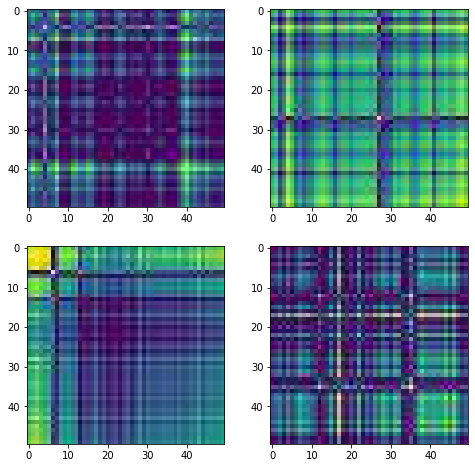

In [82]:
visualize_data_loader(train_gaf_loader, validation_gaf_loader)

In [83]:
gaf_model = BaselineNetwork(number_of_classes=len(gaf_idx_to_class), image_size=50)

In [84]:
checkpoint_callback_gaf = pl.callbacks.ModelCheckpoint(
    dirpath="checkpoints/CR-GAF",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="Loss/valid",
    mode="min"
)
logger_gaf = pl_loggers.TensorBoardLogger("logs/", name="CR-GAF")

trainer_gaf = pl.Trainer(max_epochs=18, log_every_n_steps=1, logger=logger_gaf, callbacks=[checkpoint_callback_gaf])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [85]:
trainer_gaf.fit(gaf_model, train_dataloaders=train_gaf_loader, val_dataloaders=validation_gaf_loader)


  | Name    | Type             | Params
---------------------------------------------
0 | conv1   | Conv2d           | 168   
1 | conv2   | Conv2d           | 660   
2 | maxpool | MaxPool2d        | 0     
3 | dropout | Dropout          | 0     
4 | linear1 | Linear           | 960 K 
5 | linear2 | Linear           | 8.3 K 
6 | linear3 | Linear           | 130   
7 | loss    | CrossEntropyLoss | 0     
---------------------------------------------
969 K     Trainable params
0         Non-trainable params
969 K     Total params
3.877     Total estimated model params size (MB)


/opt/anaconda3/envs/unibern-pytorch/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/anaconda3/envs/unibern-pytorch/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 72/72 [00:03<00:00, 22.40it/s, loss=0.696, v_num=6, Loss/valid=0.699, Accuracy/valid=0.352, Loss/train=0.697, Accuracy/train=0.445]

Epoch 0, global step 49: Loss/valid reached 0.69936 (best 0.69936), saving model to "/Users/oliver.hofmann/Documents/Source/cas-aml/crypto-ransomware-detection/checkpoints/CR-GAF/best-checkpoint.ckpt" as top 1


Epoch 1: 100%|██████████| 72/72 [00:03<00:00, 21.74it/s, loss=0.691, v_num=6, Loss/valid=0.687, Accuracy/valid=0.750, Loss/train=0.692, Accuracy/train=0.535]

Epoch 1, global step 99: Loss/valid reached 0.68672 (best 0.68672), saving model to "/Users/oliver.hofmann/Documents/Source/cas-aml/crypto-ransomware-detection/checkpoints/CR-GAF/best-checkpoint.ckpt" as top 1


Epoch 2: 100%|██████████| 72/72 [00:02<00:00, 25.32it/s, loss=0.675, v_num=6, Loss/valid=0.664, Accuracy/valid=0.659, Loss/train=0.683, Accuracy/train=0.675]

Epoch 2, global step 149: Loss/valid reached 0.66393 (best 0.66393), saving model to "/Users/oliver.hofmann/Documents/Source/cas-aml/crypto-ransomware-detection/checkpoints/CR-GAF/best-checkpoint.ckpt" as top 1


Epoch 3: 100%|██████████| 72/72 [00:02<00:00, 27.59it/s, loss=0.657, v_num=6, Loss/valid=0.649, Accuracy/valid=0.682, Loss/train=0.670, Accuracy/train=0.640]

Epoch 3, global step 199: Loss/valid reached 0.64874 (best 0.64874), saving model to "/Users/oliver.hofmann/Documents/Source/cas-aml/crypto-ransomware-detection/checkpoints/CR-GAF/best-checkpoint.ckpt" as top 1


Epoch 4: 100%|██████████| 72/72 [00:02<00:00, 32.56it/s, loss=0.66, v_num=6, Loss/valid=0.642, Accuracy/valid=0.682, Loss/train=0.660, Accuracy/train=0.625] 

Epoch 4, global step 249: Loss/valid reached 0.64234 (best 0.64234), saving model to "/Users/oliver.hofmann/Documents/Source/cas-aml/crypto-ransomware-detection/checkpoints/CR-GAF/best-checkpoint.ckpt" as top 1


Epoch 5: 100%|██████████| 72/72 [00:02<00:00, 33.75it/s, loss=0.649, v_num=6, Loss/valid=0.611, Accuracy/valid=0.761, Loss/train=0.648, Accuracy/train=0.650]

Epoch 5, global step 299: Loss/valid reached 0.61097 (best 0.61097), saving model to "/Users/oliver.hofmann/Documents/Source/cas-aml/crypto-ransomware-detection/checkpoints/CR-GAF/best-checkpoint.ckpt" as top 1


Epoch 6: 100%|██████████| 72/72 [00:01<00:00, 36.33it/s, loss=0.609, v_num=6, Loss/valid=0.575, Accuracy/valid=0.852, Loss/train=0.622, Accuracy/train=0.690]

Epoch 6, global step 349: Loss/valid reached 0.57451 (best 0.57451), saving model to "/Users/oliver.hofmann/Documents/Source/cas-aml/crypto-ransomware-detection/checkpoints/CR-GAF/best-checkpoint.ckpt" as top 1


Epoch 7: 100%|██████████| 72/72 [00:01<00:00, 42.61it/s, loss=0.552, v_num=6, Loss/valid=0.507, Accuracy/valid=0.795, Loss/train=0.581, Accuracy/train=0.740]

Epoch 7, global step 399: Loss/valid reached 0.50736 (best 0.50736), saving model to "/Users/oliver.hofmann/Documents/Source/cas-aml/crypto-ransomware-detection/checkpoints/CR-GAF/best-checkpoint.ckpt" as top 1


Epoch 8: 100%|██████████| 72/72 [00:02<00:00, 31.79it/s, loss=0.593, v_num=6, Loss/valid=0.513, Accuracy/valid=0.852, Loss/train=0.571, Accuracy/train=0.715]

Epoch 8, global step 449: Loss/valid was not in top 1


Epoch 9: 100%|██████████| 72/72 [00:02<00:00, 32.12it/s, loss=0.496, v_num=6, Loss/valid=0.451, Accuracy/valid=0.852, Loss/train=0.529, Accuracy/train=0.805]

Epoch 9, global step 499: Loss/valid reached 0.45143 (best 0.45143), saving model to "/Users/oliver.hofmann/Documents/Source/cas-aml/crypto-ransomware-detection/checkpoints/CR-GAF/best-checkpoint.ckpt" as top 1


Epoch 10: 100%|██████████| 72/72 [00:01<00:00, 39.62it/s, loss=0.462, v_num=6, Loss/valid=0.533, Accuracy/valid=0.739, Loss/train=0.508, Accuracy/train=0.780]

Epoch 10, global step 549: Loss/valid was not in top 1


Epoch 11: 100%|██████████| 72/72 [00:01<00:00, 42.32it/s, loss=0.406, v_num=6, Loss/valid=0.482, Accuracy/valid=0.750, Loss/train=0.454, Accuracy/train=0.785]

Epoch 11, global step 599: Loss/valid was not in top 1


Epoch 12: 100%|██████████| 72/72 [00:01<00:00, 44.34it/s, loss=0.442, v_num=6, Loss/valid=0.512, Accuracy/valid=0.739, Loss/train=0.431, Accuracy/train=0.820]

Epoch 12, global step 649: Loss/valid was not in top 1


Epoch 13: 100%|██████████| 72/72 [00:01<00:00, 38.80it/s, loss=0.422, v_num=6, Loss/valid=0.439, Accuracy/valid=0.795, Loss/train=0.442, Accuracy/train=0.815]

Epoch 13, global step 699: Loss/valid reached 0.43891 (best 0.43891), saving model to "/Users/oliver.hofmann/Documents/Source/cas-aml/crypto-ransomware-detection/checkpoints/CR-GAF/best-checkpoint.ckpt" as top 1


Epoch 14: 100%|██████████| 72/72 [00:01<00:00, 37.38it/s, loss=0.423, v_num=6, Loss/valid=0.457, Accuracy/valid=0.784, Loss/train=0.433, Accuracy/train=0.790]

Epoch 14, global step 749: Loss/valid was not in top 1


Epoch 15: 100%|██████████| 72/72 [00:01<00:00, 42.98it/s, loss=0.398, v_num=6, Loss/valid=0.407, Accuracy/valid=0.841, Loss/train=0.382, Accuracy/train=0.835]

Epoch 15, global step 799: Loss/valid reached 0.40701 (best 0.40701), saving model to "/Users/oliver.hofmann/Documents/Source/cas-aml/crypto-ransomware-detection/checkpoints/CR-GAF/best-checkpoint.ckpt" as top 1


Epoch 16: 100%|██████████| 72/72 [00:01<00:00, 39.12it/s, loss=0.369, v_num=6, Loss/valid=0.530, Accuracy/valid=0.727, Loss/train=0.373, Accuracy/train=0.840]

Epoch 16, global step 849: Loss/valid was not in top 1


Epoch 17: 100%|██████████| 72/72 [00:01<00:00, 40.85it/s, loss=0.42, v_num=6, Loss/valid=0.644, Accuracy/valid=0.705, Loss/train=0.382, Accuracy/train=0.830] 

Epoch 17, global step 899: Loss/valid was not in top 1


Epoch 17: 100%|██████████| 72/72 [00:01<00:00, 40.66it/s, loss=0.42, v_num=6, Loss/valid=0.644, Accuracy/valid=0.705, Loss/train=0.382, Accuracy/train=0.830]


In [56]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6012 (pid 25844), started 1:27:50 ago. (Use '!kill 25844' to kill it.)

### Verify the model

In [86]:
validation_model_gaf = BaselineNetwork(number_of_classes=len(gaf_idx_to_class), image_size=50)
checkpoint_gaf = torch.load("checkpoints/CR-GAF/best-checkpoint.ckpt")

validation_model_gaf.load_state_dict(checkpoint_gaf["state_dict"])
validation_model_gaf.eval()

BaselineNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear1): Linear(in_features=7500, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=2, bias=True)
  (loss): CrossEntropyLoss()
)

              precision    recall  f1-score   support

      benign       0.83      1.00      0.91        10
  ransomware       1.00      0.80      0.89        10

    accuracy                           0.90        20
   macro avg       0.92      0.90      0.90        20
weighted avg       0.92      0.90      0.90        20



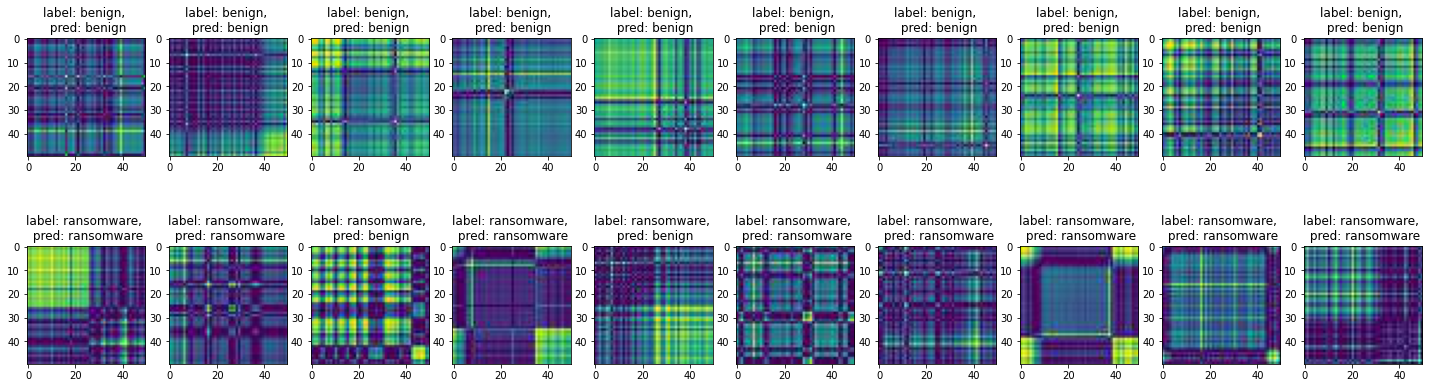

In [87]:
test_gaf_dataloader = DataLoader(test_gaf_dataset, batch_size=1, num_workers=0)
eval_model(test_gaf_dataloader, gaf_idx_to_class, validation_model_gaf)

## Experiment for Markov transition

In [88]:
benign_mtf_path = "features/images/benign/mtf/cache_references"
ransomware_mtf_path = "features/images/ransomware/mtf/cache_references"

print("Benign samples", len(glob.glob(os.path.join(benign_mtf_path, "*"))))
print("Ransomware samples", len(glob.glob(os.path.join(ransomware_mtf_path, "*"))))

Benign samples 176
Ransomware samples 176


In [89]:
train_mtf_image_paths, valid_mtf_image_paths, test_mtf_image_paths, mtf_idx_to_class, mtf_class_to_idx = create_path_datasets(benign_mtf_path, ransomware_mtf_path)

train_mtf_dataset = RansomwareDetectionDataset(train_mtf_image_paths, mtf_class_to_idx, transform=train_transformations)
validation_mtf_dataset = RansomwareDetectionDataset(valid_mtf_image_paths, mtf_class_to_idx, transform=validation_transformations)
test_mtf_dataset = RansomwareDetectionDataset(test_mtf_image_paths, mtf_class_to_idx, transform=test_transformation)

print(f"Tensor shape of the image: {train_mtf_dataset[1][0].shape}")
print(f"Label of the image: {mtf_idx_to_class[train_mtf_dataset[1][1]]}")

Test dataset len: 20
Train validation dataset len: 286
Path example: features/images/benign/mtf/cache_references/benign_52.jpg
Class example: benign
Train size: 200
Valid size 86
Tensor shape of the image: torch.Size([3, 50, 50])
Label of the image: ransomware


In [90]:
train_mtf_loader, validation_mtf_loader = create_dataloaders(train_mtf_dataset, validation_mtf_dataset)

Train dataloader shape torch.Size([4, 3, 50, 50])
Validation dataloader shape torch.Size([4, 3, 50, 50])


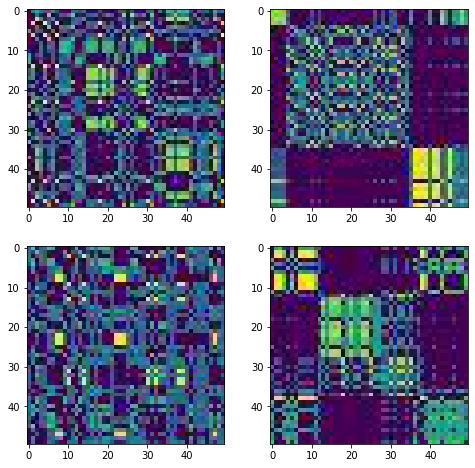

In [91]:
visualize_data_loader(train_mtf_loader, validation_mtf_loader)

In [92]:
mtf_model = BaselineNetwork(number_of_classes=len(mtf_idx_to_class), image_size=50)

In [94]:
checkpoint_callback_mtf = pl.callbacks.ModelCheckpoint(
    dirpath="checkpoints/CR-MTF",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="Loss/valid",
    mode="min"
)
logger_mtf = pl_loggers.TensorBoardLogger("logs/", name="CR-MTF")

trainer_mtf = pl.Trainer(max_epochs=10, log_every_n_steps=1, logger=logger_mtf, callbacks=[checkpoint_callback_mtf])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [95]:
trainer_mtf.fit(mtf_model, train_dataloaders=train_mtf_loader, val_dataloaders=validation_mtf_loader)


  | Name    | Type             | Params
---------------------------------------------
0 | conv1   | Conv2d           | 168   
1 | conv2   | Conv2d           | 660   
2 | maxpool | MaxPool2d        | 0     
3 | dropout | Dropout          | 0     
4 | linear1 | Linear           | 960 K 
5 | linear2 | Linear           | 8.3 K 
6 | linear3 | Linear           | 130   
7 | loss    | CrossEntropyLoss | 0     
---------------------------------------------
969 K     Trainable params
0         Non-trainable params
969 K     Total params
3.877     Total estimated model params size (MB)


/opt/anaconda3/envs/unibern-pytorch/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/anaconda3/envs/unibern-pytorch/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 72/72 [00:03<00:00, 23.68it/s, loss=0.683, v_num=1, Loss/valid=0.684, Accuracy/valid=0.568, Loss/train=0.685, Accuracy/train=0.590]

Epoch 0, global step 49: Loss/valid reached 0.68433 (best 0.68433), saving model to "/Users/oliver.hofmann/Documents/Source/cas-aml/crypto-ransomware-detection/checkpoints/CR-MTF/best-checkpoint.ckpt" as top 1


Epoch 1: 100%|██████████| 72/72 [00:02<00:00, 26.25it/s, loss=0.682, v_num=1, Loss/valid=0.680, Accuracy/valid=0.568, Loss/train=0.678, Accuracy/train=0.590]

Epoch 1, global step 99: Loss/valid reached 0.67976 (best 0.67976), saving model to "/Users/oliver.hofmann/Documents/Source/cas-aml/crypto-ransomware-detection/checkpoints/CR-MTF/best-checkpoint.ckpt" as top 1


Epoch 2: 100%|██████████| 72/72 [00:02<00:00, 24.07it/s, loss=0.688, v_num=1, Loss/valid=0.676, Accuracy/valid=0.568, Loss/train=0.670, Accuracy/train=0.590]

Epoch 2, global step 149: Loss/valid reached 0.67583 (best 0.67583), saving model to "/Users/oliver.hofmann/Documents/Source/cas-aml/crypto-ransomware-detection/checkpoints/CR-MTF/best-checkpoint.ckpt" as top 1


Epoch 3: 100%|██████████| 72/72 [00:04<00:00, 17.30it/s, loss=0.668, v_num=1, Loss/valid=0.671, Accuracy/valid=0.568, Loss/train=0.665, Accuracy/train=0.590]

Epoch 3, global step 199: Loss/valid reached 0.67125 (best 0.67125), saving model to "/Users/oliver.hofmann/Documents/Source/cas-aml/crypto-ransomware-detection/checkpoints/CR-MTF/best-checkpoint.ckpt" as top 1


Epoch 4: 100%|██████████| 72/72 [00:02<00:00, 33.59it/s, loss=0.675, v_num=1, Loss/valid=0.670, Accuracy/valid=0.568, Loss/train=0.659, Accuracy/train=0.590]

Epoch 4, global step 249: Loss/valid reached 0.66983 (best 0.66983), saving model to "/Users/oliver.hofmann/Documents/Source/cas-aml/crypto-ransomware-detection/checkpoints/CR-MTF/best-checkpoint.ckpt" as top 1


Epoch 5: 100%|██████████| 72/72 [00:01<00:00, 39.48it/s, loss=0.644, v_num=1, Loss/valid=0.663, Accuracy/valid=0.568, Loss/train=0.652, Accuracy/train=0.590]

Epoch 5, global step 299: Loss/valid reached 0.66264 (best 0.66264), saving model to "/Users/oliver.hofmann/Documents/Source/cas-aml/crypto-ransomware-detection/checkpoints/CR-MTF/best-checkpoint.ckpt" as top 1


Epoch 6: 100%|██████████| 72/72 [00:01<00:00, 38.09it/s, loss=0.627, v_num=1, Loss/valid=0.655, Accuracy/valid=0.568, Loss/train=0.641, Accuracy/train=0.620]

Epoch 6, global step 349: Loss/valid reached 0.65516 (best 0.65516), saving model to "/Users/oliver.hofmann/Documents/Source/cas-aml/crypto-ransomware-detection/checkpoints/CR-MTF/best-checkpoint.ckpt" as top 1


Epoch 7: 100%|██████████| 72/72 [00:01<00:00, 46.84it/s, loss=0.614, v_num=1, Loss/valid=0.638, Accuracy/valid=0.557, Loss/train=0.613, Accuracy/train=0.640]

Epoch 7, global step 399: Loss/valid reached 0.63814 (best 0.63814), saving model to "/Users/oliver.hofmann/Documents/Source/cas-aml/crypto-ransomware-detection/checkpoints/CR-MTF/best-checkpoint.ckpt" as top 1


Epoch 8: 100%|██████████| 72/72 [00:01<00:00, 40.88it/s, loss=0.605, v_num=1, Loss/valid=0.635, Accuracy/valid=0.614, Loss/train=0.600, Accuracy/train=0.660]

Epoch 8, global step 449: Loss/valid reached 0.63485 (best 0.63485), saving model to "/Users/oliver.hofmann/Documents/Source/cas-aml/crypto-ransomware-detection/checkpoints/CR-MTF/best-checkpoint.ckpt" as top 1


Epoch 9: 100%|██████████| 72/72 [00:02<00:00, 27.71it/s, loss=0.548, v_num=1, Loss/valid=0.621, Accuracy/valid=0.636, Loss/train=0.590, Accuracy/train=0.645]

Epoch 9, global step 499: Loss/valid reached 0.62050 (best 0.62050), saving model to "/Users/oliver.hofmann/Documents/Source/cas-aml/crypto-ransomware-detection/checkpoints/CR-MTF/best-checkpoint.ckpt" as top 1


Epoch 9: 100%|██████████| 72/72 [00:02<00:00, 27.18it/s, loss=0.548, v_num=1, Loss/valid=0.621, Accuracy/valid=0.636, Loss/train=0.590, Accuracy/train=0.645]


In [65]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6012 (pid 25844), started 1:29:49 ago. (Use '!kill 25844' to kill it.)

### Verify the model

In [96]:
validation_model_mtf = BaselineNetwork(number_of_classes=len(mtf_idx_to_class), image_size=50)
checkpoint_mtf = torch.load("checkpoints/CR-MTF/best-checkpoint.ckpt")

validation_model_mtf.load_state_dict(checkpoint_mtf["state_dict"])
validation_model_mtf.eval()

BaselineNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear1): Linear(in_features=7500, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=2, bias=True)
  (loss): CrossEntropyLoss()
)

              precision    recall  f1-score   support

      benign       0.67      0.40      0.50        10
  ransomware       0.57      0.80      0.67        10

    accuracy                           0.60        20
   macro avg       0.62      0.60      0.58        20
weighted avg       0.62      0.60      0.58        20



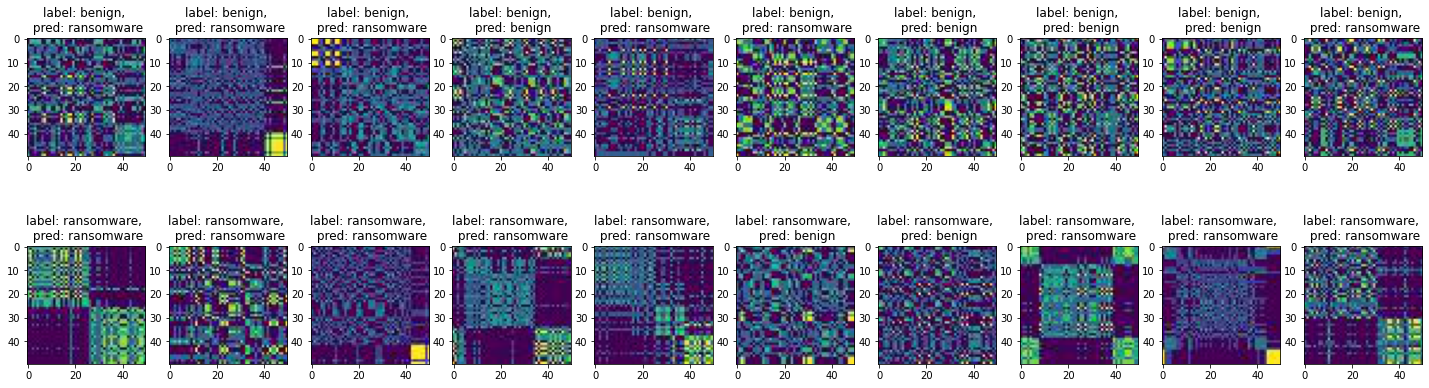

In [97]:
test_mtf_dataloader = DataLoader(test_mtf_dataset, batch_size=1, num_workers=0)
eval_model(test_mtf_dataloader, mtf_idx_to_class, validation_model_mtf)